In [1]:
# Initialize and import
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse


# Instructions

## Assignment instructions

**NOTE: You are allowed to use inbuilt functions for all of the questions unless stated otherwise.**

## Submission instructions

* You must submit a zip file containg just this notebook (replace XXXXXXXX with your roll number)
* The name of the zip file must be your `Roll Number`

## Dataset
Researchers in the Networks and Systems Group at LUMS conducted a large-scale measurement study of the top 1000 sites in each of the countries for which this data was available. A subset of this data for **developing regions** has been compiled into the dataset we will be using for this assignment.

Here is a description of the data:
- Each of the rows represent a 'run' of a unique URL (e.g. www.dawn.com). A 'run' is a full load of a webpage on a mobile device.
- ***requests.xxx*** represents the total count of object type xxx (e.g requests.images represents the number of images on that URL)
- ***bytes.xxx*** represents the total bytes contributed by object type xxx
- ***fullyLoaded*** represents the number of milliseconds it took to load that webpage (Page Load Time: PLT)

Our overarching goal is to predict -- given the number and sizes of different objects on a webpage -- how long it would take to fully load that webpage. This would also tell us how much each object contributes to page load times. Reducing page load times is a key goal of companies that provide user-facing services, such as search, recommendation systems, and social networks.

`Optional Reading`: Although not necessary, but if you are interested in learning more about Web objects (e.g., JavaScript, CSS, Fonts), here is a nice reference https://almanac.httparchive.org/en/2022/table-of-contents (Web Almanac)

Let's load the dataset.

In [3]:
df = pd.read_csv("webpage_data.csv").drop({"Unnamed: 0"},axis=1)
df

,fullyLoaded,bytesIn,requests,bytes.html,requests.html,bytes.js,requests.js,bytes.css,requests.css,bytes.image,requests.image,bytes.font,requests.font,bytes.video,requests.video,bytes.other,requests.other,id
0,9053.0,1774507.0,41.0,50146.0,14.0,1693605.0,7.0,274.0,1.0,26918.0,14.0,0.0,0.0,0.0,0.0,3564.0,5.0,221010_KJ_2
1,15271.0,2159401.0,35.0,39355.0,6.0,1496899.0,9.0,450278.0,2.0,94213.0,5.0,28719.0,2.0,0.0,0.0,49757.0,10.0,221010_JC_3
2,10687.0,2601.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2601.0,2.0,221010_FS_4
3,10284.0,1768305.0,43.0,49946.0,16.0,1691559.0,7.0,274.0,1.0,21934.0,14.0,0.0,0.0,0.0,0.0,4592.0,5.0,221010_C4_5
4,23532.0,2199183.0,207.0,60672.0,21.0,1309642.0,46.0,45240.0,8.0,727130.0,104.0,30120.0,3.0,0.0,0.0,26379.0,25.0,221010_RJ_6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,4742.0,2601.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2601.0,1.0,221010_2G_Z5
806,20666.0,2087634.0,150.0,252014.0,39.0,503842.0,28.0,125074.0,12.0,1108590.0,45.0,84567.0,4.0,0.0,0.0,13547.0,22.0,221010_JK_Z6
807,28615.0,7873140.0,202.0,84776.0,9.0,1708867.0,43.0,165148.0,7.0,5339746.0,70.0,562508.0,48.0,0.0,0.0,12095.0,24.0,221010_TB_Z7
808,27612.0,2107225.0,198.0,21893.0,7.0,1237906.0,49.0,241761.0,1.0,419819.0,69.0,181456.0,7.0,0.0,0.0,4390.0,65.0,221010_7S_Z8


In [4]:
df.describe()

,fullyLoaded,bytesIn,requests,bytes.html,requests.html,bytes.js,requests.js,bytes.css,requests.css,bytes.image,requests.image,bytes.font,requests.font,bytes.video,requests.video,bytes.other,requests.other
count,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000,8.100000e+02,810.000000
mean,25488.158025,3.476777e+06,130.003704,7.879481e+04,12.814815,9.072783e+05,28.638272,1.161252e+05,7.323457,1.976130e+06,49.764198,1.424485e+05,3.635802,1.879061e+05,0.245679,6.527066e+04,26.449383
std,21598.795272,5.424316e+06,149.150851,1.272167e+05,25.091285,9.591097e+05,29.958913,1.976322e+05,9.884203,4.915819e+06,68.635761,1.961438e+05,3.743897,1.154530e+06,1.543001,2.434676e+05,56.486524
min,958.000000,8.810000e+02,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,11908.750000,8.809915e+05,45.000000,1.657750e+04,2.000000,2.266992e+05,9.000000,1.480425e+04,2.000000,1.490582e+05,13.000000,2.048200e+04,1.000000,0.000000e+00,0.000000,2.673000e+03,4.000000
50%,20495.000000,1.929332e+06,90.000000,4.278900e+04,4.000000,6.374370e+05,21.000000,5.122600e+04,4.000000,5.115840e+05,31.000000,9.257200e+04,3.000000,0.000000e+00,0.000000,5.465500e+03,10.000000
75%,31593.000000,4.143882e+06,161.000000,9.660875e+04,11.000000,1.269387e+06,40.000000,1.282240e+05,9.000000,1.820019e+06,65.000000,1.860285e+05,5.000000,0.000000e+00,0.000000,3.747700e+04,22.000000
max,124011.000000,6.669134e+07,1695.000000,1.894586e+06,262.000000,6.836651e+06,361.000000,2.132118e+06,90.000000,6.281735e+07,1131.000000,2.991552e+06,48.000000,1.750543e+07,20.000000,2.633695e+06,715.000000


**Question 0:** Write (as a comment) *your prediction* about which objects would contribute the most to Page Load Times (PLTs) (this question is open-ended and may not have a single correct answer).

In [15]:
# Comment here
# Videos and image objects would contribute the most to PLT since they normally use the max amount of data and would take longer to load. 

## Data cleaning and splitting

**Question 1:** Now that you are well versed in data cleaning and exploratory data analysis, conduct some cleaning in order to make your predictions more accurate and explore data.

*Hint: Remove non-numerical data. Display the correlation heatmap of your variables. Try excluding explanatory variables that are dependant on each other or have a very small impact on the predicted variable.*

In [5]:
# Code here
df = df.drop('id', axis=1)
df

,fullyLoaded,bytesIn,requests,bytes.html,requests.html,bytes.js,requests.js,bytes.css,requests.css,bytes.image,requests.image,bytes.font,requests.font,bytes.video,requests.video,bytes.other,requests.other
0,9053.0,1774507.0,41.0,50146.0,14.0,1693605.0,7.0,274.0,1.0,26918.0,14.0,0.0,0.0,0.0,0.0,3564.0,5.0
1,15271.0,2159401.0,35.0,39355.0,6.0,1496899.0,9.0,450278.0,2.0,94213.0,5.0,28719.0,2.0,0.0,0.0,49757.0,10.0
2,10687.0,2601.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2601.0,2.0
3,10284.0,1768305.0,43.0,49946.0,16.0,1691559.0,7.0,274.0,1.0,21934.0,14.0,0.0,0.0,0.0,0.0,4592.0,5.0
4,23532.0,2199183.0,207.0,60672.0,21.0,1309642.0,46.0,45240.0,8.0,727130.0,104.0,30120.0,3.0,0.0,0.0,26379.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,4742.0,2601.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2601.0,1.0
806,20666.0,2087634.0,150.0,252014.0,39.0,503842.0,28.0,125074.0,12.0,1108590.0,45.0,84567.0,4.0,0.0,0.0,13547.0,22.0
807,28615.0,7873140.0,202.0,84776.0,9.0,1708867.0,43.0,165148.0,7.0,5339746.0,70.0,562508.0,48.0,0.0,0.0,12095.0,24.0
808,27612.0,2107225.0,198.0,21893.0,7.0,1237906.0,49.0,241761.0,1.0,419819.0,69.0,181456.0,7.0,0.0,0.0,4390.0,65.0


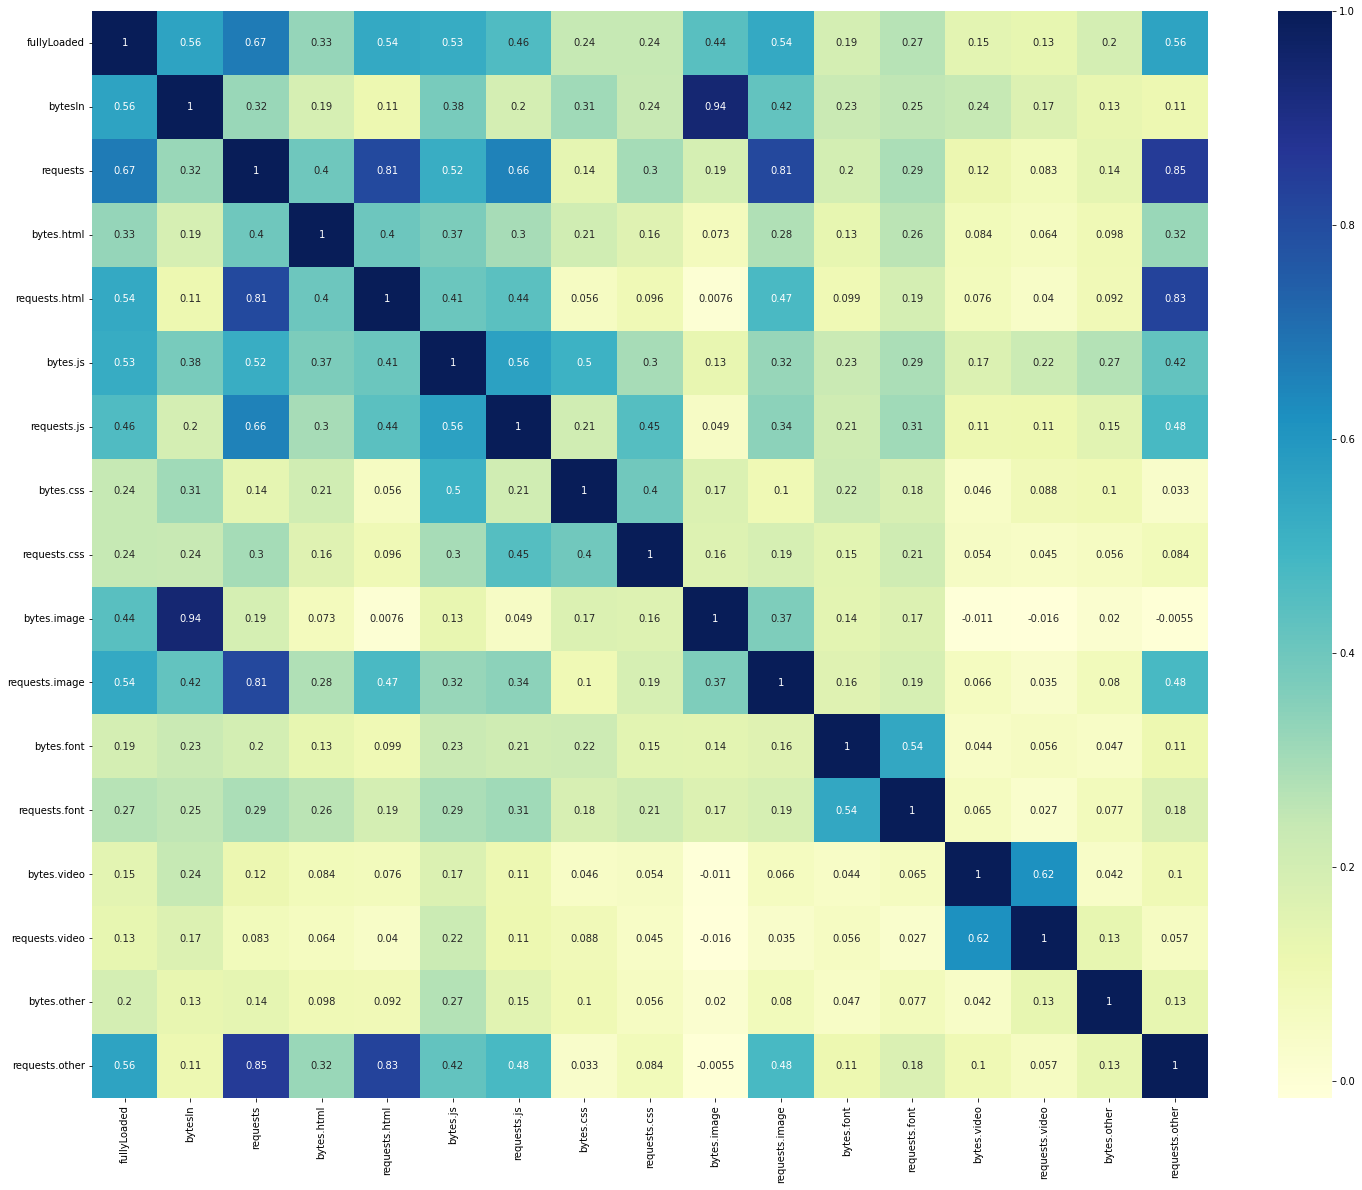

In [6]:
plt.figure(figsize=(25,20))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [7]:
# drop columns with correlation <=30% and high sparsity.  
df = df.drop(['requests.css', 'bytes.css', 'bytes.video', 'bytes.other', 'requests.video', 'bytes.font'], axis=1)
df

,fullyLoaded,bytesIn,requests,bytes.html,requests.html,bytes.js,requests.js,bytes.image,requests.image,requests.font,requests.other
0,9053.0,1774507.0,41.0,50146.0,14.0,1693605.0,7.0,26918.0,14.0,0.0,5.0
1,15271.0,2159401.0,35.0,39355.0,6.0,1496899.0,9.0,94213.0,5.0,2.0,10.0
2,10687.0,2601.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
3,10284.0,1768305.0,43.0,49946.0,16.0,1691559.0,7.0,21934.0,14.0,0.0,5.0
4,23532.0,2199183.0,207.0,60672.0,21.0,1309642.0,46.0,727130.0,104.0,3.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...
805,4742.0,2601.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
806,20666.0,2087634.0,150.0,252014.0,39.0,503842.0,28.0,1108590.0,45.0,4.0,22.0
807,28615.0,7873140.0,202.0,84776.0,9.0,1708867.0,43.0,5339746.0,70.0,48.0,24.0
808,27612.0,2107225.0,198.0,21893.0,7.0,1237906.0,49.0,419819.0,69.0,7.0,65.0


**Question 2:**

a) Create a 70-30 train-test split. Assign your train data to `train_df` and your test data to `test_df`

b) Divide `train_df` into input and output variables (train_X and train_y). Divide `test_df` into input and output variables (test_X and test_y). 

In [19]:
# Code here

train_df, test_df = train_test_split(df, test_size=0.30, shuffle = True) #split data set. 

train_Y = train_df['fullyLoaded']
train_X = train_df.drop('fullyLoaded', axis=1)

test_Y = test_df['fullyLoaded']
test_X = test_df.drop('fullyLoaded', axis=1)


In [20]:
train_X.head(5)

,bytesIn,requests,bytes.html,requests.html,bytes.js,requests.js,bytes.image,requests.image,requests.font,requests.other
79,11884.0,4.0,7107.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
308,4356610.0,411.0,105715.0,43.0,1599483.0,68.0,2303885.0,171.0,5.0,103.0
610,6056265.0,351.0,228806.0,55.0,3387191.0,113.0,2093964.0,87.0,5.0,77.0
648,2601.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
274,1990621.0,86.0,67401.0,2.0,889996.0,21.0,878083.0,40.0,8.0,11.0


In [21]:
train_Y.head(5)

79      7597.0
308    41202.0
610    56855.0
648     4892.0
274    28647.0
Name: fullyLoaded, dtype: float64

We will now be using the train data for machine learning.

## Linear Regression

**Question 3:** Use Statsmodels to train a multiple linear regression model on the data. Note that the value we are aiming to predict is `fullyloaded`, and we will be using Ordinary Least Squares. Print out the summary of your model.

*Note: Do not forget to add a constant bias variable.* 

In [22]:
# Code here
train_X=sm.add_constant(train_X)       
model= sm.OLS(train_Y, train_X).fit()       
predictions= model.summary() 
predictions    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fullyLoaded   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     86.43
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          2.08e-106
Time:                        22:22:57   Log-Likelihood:                -6203.4
No. Observations:                 567   AIC:                         1.243e+04
Df Residuals:                     556   BIC:                         1.248e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9187.9480    971.884      9.454      0.000    7278.935    1.11e+04
bytesIn            0.0009      0.000      2.135      0.033    7.56e-05       0.002
requests         100.9663     65.494      1.542      0.124     -27.680     229.613
bytes.html         0.0040      0.005      0.840      0.401      -0.005       0.013
requests.html   -114.6081     77.647     -1.476      0.141    -267.126      37.910
bytes.js           0.0033      0.001      3.302      0.001       0.001       0.005
requests.js      -24.0728     78.660     -0.306      0.760    -178.579     130.434
bytes.image        0.0007      0.000      1.452      0.147      -0.000       0.002
requests.image   -62.6824     66.475     -0.943      0.346    -193.255      67.890
requests.font   -120.5739    204.448     -0.590      0.556    -522.158     281.011
requests.other    41.6879     67.070      0.622      0.534     -90.053     173.429
==============================================================================
Omnibus:                      520.867   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14993.376
Skew:                           4.088   Prob(JB):                         0.00
Kurtosis:                      26.829   Cond. No.                     1.41e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Question 4a:** Comment on the statistical significance of your variables in predicting PLTs.

In [ ]:
# Comment here

# p value less than 0.05 is statistically significant.
# variable      p-values
# bytesIn		0.033	statisitically significant. 
# requests   	0.124	not statisitically significant.
# bytes.html	0.401   not statisitically significant.
# requests.html	0.141	not statisitically significant.
# bytes.js		0.001	statisitically significant.
# requests.js   0.760	not statisitically significant.
# bytes.image	0.147	not statisitically significant.
# requests.image 0.346	not statisitically significant.
# requests.font  0.556	not statisitically significant.
# requests.other 0.534  not statisitically significant.

**Question 4b:** Why are the coefficient of variables starting with the name `bytes*` much smaller than the coefficients of variables whose names begin with `request*`?

In [ ]:
# Comment here
# that is because variables starting with bytes have a less effect on fullyLoaded variable than those starting with requests since requests has object which would take longer time to load.  

**Question 5:** What does the coefficient of the `requests` variable tell you about how the number of objects on a page affect the PLT of *an arbitrary webpage*? Specifically, if we have two similar webpages A and B that only differ by the fact that A has 2 extra objects, what can you say about the difference between the PLTs of A and B?

In [ ]:
# Comment here
# The coefficient of requests is 100.9663. That means for increase in one object on an arbitrary website, the PLT increases by 100.9663 units. 
# If A has 2 extra objects compared to B, the PLT increases by 2*100.9663 units -> 201.9326 units. 


**Question 6:** Plot a graph of
- your 3 most significant explanatory variables on the x axis and
- the predicted variable `fullyLoaded` on the y axis

Note: You are expected to plot all three explanatory variables on the same graph. You can use any EDA technique as long as you can ascertain a trend between the variables (if any).

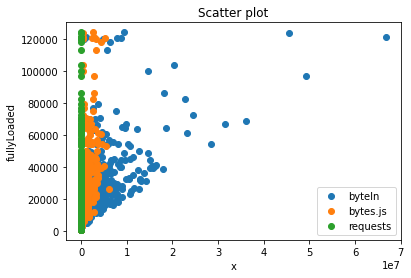

In [38]:
# Code here
#bytesIn, bytes.js, requests
plt.scatter(x = train_X['bytesIn'], y =train_Y, label = 'byteIn')
plt.scatter(x = train_X['bytes.js'], y = train_Y, label = 'bytes.js')
plt.scatter(x = train_X['requests'], y= train_Y, label = 'requests')

plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('fullyLoaded')
plt.legend()
plt.show()


**Question 7:** Considering the plot you made in Question 5, was a linear model a good choice? Why or why not?

In [ ]:
# Comment here
# No a linear model was not a good choice for this data. 
# bytes.js and requests have a gradient that is approaching infinity. 
# bytesIn has a weak linear correlation. Much of the data is either conjested near the origin or has a high divergance ahead for which a linear model is not a good estimate.  

**Question 8**: Implement the function `RMSE` that takes as an input 
- The output column in `test_df` and 
- The *predicted* output column of the `test_df`.

The output of this function should be the Root Mean Square Error (RMSE) of the prediction. You must calculate this from scratch (and you are not allowed to use loops).

Use this function to print out the RMSE of your Statsmodels OLS model.

In [9]:

def RMSE(y, y_hat):
    return np.sqrt(np.mean((np.array(y_hat) - np.array(y) )**2))


# add constant and predict on model.
test_X = sm.add_constant(test_X)
test_pred = model.predict(test_X)

rmse = RMSE(test_Y, test_pred)
print("RMSE: ", rmse)



**Question 9:** In class you studied this formula to find the optimal parameters in a linear model:

$\theta = (X^{T}X)^{-1}X^{T}y$

Write a function to implement this formula from scratch. Compare the parameters you get from this formula to those generated by Statsmodel (as a comment) by comparing the RMSE (of the test data).

In [25]:
# Code here
def optimalParameters(train_x, train_y):
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    # print(train_x.shape, train_y.shape)
    transpose_x = np.transpose(train_x)
    temp = np.linalg.inv(np.dot(transpose_x, train_x))
    temp2 = np.dot(temp,transpose_x)
    optimal_param = np.dot( temp2, train_y)
    return optimal_param

opt_params = optimalParameters(test_X, test_Y)
# print(test_X.shape, opt_params.shape)
opt_params_y = np.dot(test_X, opt_params)
rmse_opt = RMSE(test_Y, opt_params_y)
print("RMSE on optimal parameters created from scratch: ", rmse_opt)



RMSE on optimal parameters created from scratch:  11807.321062364004


In [ ]:
# Comment here
# The RMSE on optimal parameters created from scratch less than that calculated from the model. 

## Regularized regressions

**Question 10:** Use sklearn to perform Ridge regression on the data. Evaluate Ridge regression for a range of $\alpha$ values to find the optimal $\alpha$. Report the MSE of the model for the optimal $\alpha$ on the test set.

In [26]:
# Code here

alpha = np.array([10e-10, 10e-5, 10, 10e+5,10e+10]) 
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Ridge(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alpha = alphas[i]

print("alpha", alpha)
print("MSE: ",min(mse_error))


alpha 1000000.0
MSE:  177917851.37433586


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.01533e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.01533e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


**Question 11:** As the value of $\alpha$ increases, you will notice the the weights of the model parameters will start to change. Plot the values of all the weights against $\log(\alpha$) on a single figure. Describe what you see.

Text(0.5, 1.0, 'Ridge regularization vs parameters')

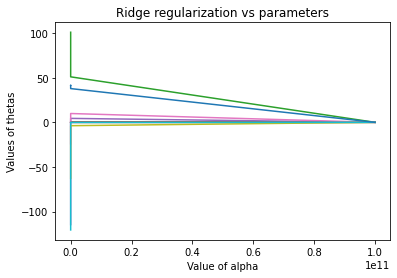

In [27]:
# Code here
coeffecient = np.array(coeffecient)
plt.plot(alphas, coeffecient)
plt.xlabel("Value of alpha")
plt.ylabel("Values of thetas")
plt.title("Ridge regularization vs parameters")

**Question 12:** Use sklearn to perform Lasso regression on the data. Evaluate Lasso regression for a range of $\alpha$ values to find the optimal $\alpha$. Report the MSE of the model for the optimal $\alpha$ on the test set.

In [29]:
# Code here
alpha = np.array([10e-20, 10e-15, 10e-10, 10e-5, 10, 10e+5,10e+10, 10e+15, 10e+20])

coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Lasso(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alpha = alphas[i]

print("alpha", alpha)
print("MSE: ",min(mse_error))


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e+10, tolerance: 2.700e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 

alpha 10.0
MSE:  191945284.7409521


**Question 13:** As the value of $\alpha$ increases, you will notice the the weights of the model parameters will start to change. Plot the values of all the weights against $\log(\alpha$) on a single figure. Describe what you see. It is different from Ridge regression?

Text(0.5, 1.0, 'Lasso vs parameters')

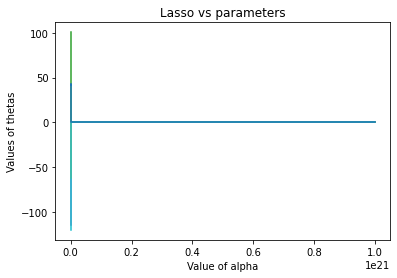

In [30]:
# Code here
coeffecient = np.array(coeffecient)
plt.plot(alphas, coeffecient)
plt.xlabel("Value of alpha")
plt.ylabel("Values of thetas")
plt.title("Lasso vs parameters")

## Decision trees

**Question 14:** On the same train data, use a decision tree regressor (such as that provided by sklearn). Find the RMSE of the test data on the new predictions generateed by your decision tree model. Compare this with your linear model at three values of max_depths: 2, 5, and 10

In [104]:
# Code here
m = [2,5,10]
predict = []
err = []
for i in m:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(train_X, train_Y)
    predict_y = clf.predict(test_X)
    err.append(RMSE(test_Y, predict_y))
    predict.append(predict_y)

print(err)


[20522.470927025755, 27507.31338451185, 28084.94789526652]


In [ ]:
# As max_depth increases, the error increases. 
# The error is higher for decision tree at all depths as compared to linear model. 

## Random forests

**Question 15:** A sklearn random forest model has variable number of estimators and maximum depth of trees. Selecting suitable ranges for both parameters, plot a 3D plot of the RMSE against both of these parameters. What do you see? For the optimal values of these parameters report the RMSE on the test data.

Note: To learn more about how to use the random forest model in sklearn, please refer to the following link: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [32]:
# Code here
m = [2,5,10]
num_est = [100,200,300,100,200,300]
errors = {}
for i in m: 
    e = []
    for j in num_est:
        r_f = RandomForestRegressor(max_depth = i,n_estimators = j )
        r_f.fit(train_X, train_Y)
        pred_r_f = r_f.predict(test_X)
        err = RMSE(test_Y, pred_r_f)
        e.append(err)
    errors[i] = max(e)

errors

{2: 13764.27956099521, 5: 12005.560033311316, 10: 12349.441833611643}

3


<function matplotlib.pyplot.show(close=None, block=None)>

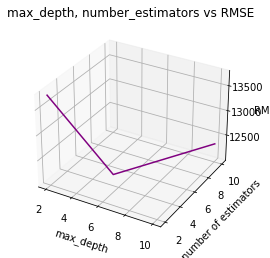

In [33]:
# 3D plt.
f = plt.figure()
axs = plt.axes(projection = '3d')
num_est = list(errors.keys())
rms_error = list(errors.values())
print(len(num_est))

axs.plot3D(m, num_est, rms_error, color = 'purple')
axs.set_title("max_depth, number_estimators vs RMSE")
axs.set_xlabel ("max_depth")
axs.set_ylabel("number of estimators")
axs.set_zlabel("RMSE")
plt.show

In [35]:
ind = rms_error.index(min(rms_error))
min = num_est[ind]
minn = m[ind]
print("num_estimator: ", min, " max_depth" , minn)

num_estimator:  5  max_depth 5


**Question 16:** There are other hyperparameters in a random forest model. Play with them to find values that give a lower RMSE on the test data than what you found above. There is no fixed method for this so you are free to use and adapt any hyperparameter.

In [165]:
# Code here
m = [2,5,10]
max_features = ['sqrt', 'log2', None]
min_split = []
errors = {}
e_final = {}

for i in m: 
    e = []
    for j in max_features:
            r_f = RandomForestRegressor(max_depth = 5,n_estimators = 200, min_samples_split = i, max_features = j , bootstrap = True)
            r_f.fit(train_X, train_Y)
            pred_r_f = r_f.predict(test_X)
            err = RMSE(test_Y, pred_r_f)
            e.append(err)
    errors[i] = max(e)

errors

{2: 14700.91478123169, 5: 14607.759643529498, 10: 14680.452683535905}

In [ ]:
# The minimum error now is 14607.75 as compared to minimum error before which was 14941.29. 


## Open ended research question

**Question 17:** A large part of machine learning is about using prior domain knowledge or doing research/exploration to find a model that suits your dataset. This could also involve adjusting hyperparameters, doing feature engineering, or using a new approach altogether.

Your final task is to find a model that has the lowest RMSE across **all** the following train-test split ratios (on the provided dataset).

1. 90% Train, 10% Test
2. 70% Train, 30% Test
3. 50% Train, 50% Test
4. 30% Train, 70% Test

For this part, you can only use the following five model types: OLS, Ridge, Lasso, Decision Tree, or a Random Forest Model. You are free to tune the hyperparameters or do feature engineering.

For output purposes, fit suitable instances of all the model types on your training data and print the RMSE (of the test data) across the four train-test splits seperately.

RMSE for OLS:  17625.79772291768
Ridge alpha 10.0
Ridge MSE:  310662335.4915142


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.2863e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.2863e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisatio

Lasso alpha 10.0
Lasso MSE:  310557069.92473906
decision tree error: [28583.24365173276, 33221.929359913185, 32800.46848092114]
3


<function matplotlib.pyplot.show(close=None, block=None)>

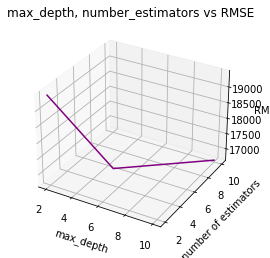

In [10]:

# Code here
# 90/10 data split. 
train_df, test_df = train_test_split(df, test_size=0.10, shuffle = True) #split data set. 
train_Y = train_df['fullyLoaded']
train_X = train_df.drop('fullyLoaded', axis=1)

test_Y = test_df['fullyLoaded']
test_X = test_df.drop('fullyLoaded', axis=1)

# OLS. 
train_X=sm.add_constant(train_X)       
split_90_10= sm.OLS(train_Y, train_X).fit()    
test_X = sm.add_constant(test_X)
test_pred = split_90_10.predict(test_X)

rmse = RMSE(test_Y, test_pred)
print("RMSE for OLS: ", rmse)

# Ridge.
alpha = np.array([10e-10, 10e-5, 10, 10e+5,10e+10]) 
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Ridge(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Ridge alpha", alphaa)
print("Ridge MSE: ",min(mse_error))



# Lasso
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Lasso(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Lasso alpha", alphaa)
print("Lasso MSE: ",min(mse_error))

# decision tree. 
m = [2,5,10]
predict = []
err = []
for i in m:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(train_X, train_Y)
    predict_y = clf.predict(test_X)
    err.append(RMSE(test_Y, predict_y))
    predict.append(predict_y)
print("decision tree error:", err)



# Random Forest 
m = [2,5,10]
num_est = [100,200,300,100,200,300]
errors = {}
for i in m: 
    e = []
    for j in num_est:
        r_f = RandomForestRegressor(max_depth = i,n_estimators = j )
        r_f.fit(train_X, train_Y)
        pred_r_f = r_f.predict(test_X)
        err = RMSE(test_Y, pred_r_f)
        e.append(err)
    errors[i] = max(e)

f = plt.figure()
axs = plt.axes(projection = '3d')
num_est = list(errors.keys())
rms_error = list(errors.values())
print(len(num_est))

axs.plot3D(m, num_est, rms_error, color = 'purple')
axs.set_title("max_depth, number_estimators vs RMSE")
axs.set_xlabel ("max_depth")
axs.set_ylabel("number of estimators")
axs.set_zlabel("RMSE")
plt.show




RMSE for OLS:  13964.94192756316
Ridge alpha 1000000.0
Ridge MSE:  186772975.21411452
Lasso alpha 10.0
Lasso MSE:  194977526.00620624


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.93402e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.93402e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

decision tree error: [21259.442262504377, 27864.08604818058, 25126.350461915066]
3


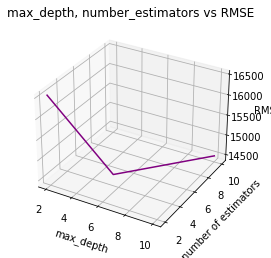

In [11]:
# Code here
# 70/30 data split. 
train_df, test_df = train_test_split(df, test_size=0.30, shuffle = True) #split data set. 
train_Y = train_df['fullyLoaded']
train_X = train_df.drop('fullyLoaded', axis=1)

test_Y = test_df['fullyLoaded']
test_X = test_df.drop('fullyLoaded', axis=1)

# OLS. 
train_X=sm.add_constant(train_X)       
split_90_10= sm.OLS(train_Y, train_X).fit()    
test_X = sm.add_constant(test_X)
test_pred = split_90_10.predict(test_X)

rmse = RMSE(test_Y, test_pred)
print("RMSE for OLS: ", rmse)

# Ridge.
alpha = np.array([10e-10, 10e-5, 10, 10e+5,10e+10]) 
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Ridge(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Ridge alpha", alphaa)
print("Ridge MSE: ",min(mse_error))

# Lasso
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Lasso(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Lasso alpha", alphaa)
print("Lasso MSE: ",min(mse_error))


# decision tree. 
m = [2,5,10]
predict = []
err = []
for i in m:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(train_X, train_Y)
    predict_y = clf.predict(test_X)
    err.append(RMSE(test_Y, predict_y))
    predict.append(predict_y)

print("decision tree error:", err)

# Random Forest 
m = [2,5,10]
num_est = [100,200,300,100,200,300]
errors = {}
for i in m: 
    e = []
    for j in num_est:
        r_f = RandomForestRegressor(max_depth = i,n_estimators = j )
        r_f.fit(train_X, train_Y)
        pred_r_f = r_f.predict(test_X)
        err = RMSE(test_Y, pred_r_f)
        e.append(err)
    errors[i] = max(e)

f = plt.figure()
axs = plt.axes(projection = '3d')
num_est = list(errors.keys())
rms_error = list(errors.values())
print(len(num_est))

axs.plot3D(m, num_est, rms_error, color = 'purple')
axs.set_title("max_depth, number_estimators vs RMSE")
axs.set_xlabel ("max_depth")
axs.set_ylabel("number of estimators")
axs.set_zlabel("RMSE")
plt.show




RMSE for OLS:  14227.398470071805
Ridge alpha 1000000.0
Ridge MSE:  201705563.43984172
Lasso alpha 10.0
Lasso MSE:  202396614.85418963


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.18209e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.18209e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

decision tree error: [25062.550978169267, 24179.7481785435, 25610.23520396619]
3


<function matplotlib.pyplot.show(close=None, block=None)>

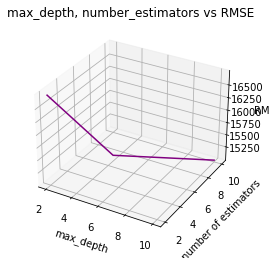

In [12]:
# Code here
# 50/50 data split. 
train_df, test_df = train_test_split(df, test_size=0.50, shuffle = True) #split data set. 
train_Y = train_df['fullyLoaded']
train_X = train_df.drop('fullyLoaded', axis=1)

test_Y = test_df['fullyLoaded']
test_X = test_df.drop('fullyLoaded', axis=1)

# OLS. 
train_X=sm.add_constant(train_X)       
split_90_10= sm.OLS(train_Y, train_X).fit()    
test_X = sm.add_constant(test_X)
test_pred = split_90_10.predict(test_X)

rmse = RMSE(test_Y, test_pred)
print("RMSE for OLS: ", rmse)

# Ridge.
alpha = np.array([10e-10, 10e-5, 10, 10e+5,10e+10]) 
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Ridge(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Ridge alpha", alphaa)
print("Ridge MSE: ",min(mse_error))

# Lasso
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Lasso(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Lasso alpha", alphaa)
print("Lasso MSE: ",min(mse_error))


# decision tree. 
m = [2,5,10]
predict = []
err = []
for i in m:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(train_X, train_Y)
    predict_y = clf.predict(test_X)
    err.append(RMSE(test_Y, predict_y))
    predict.append(predict_y)

print("decision tree error:", err)



# Random Forest 
m = [2,5,10]
num_est = [100,200,300,100,200,300]
errors = {}
for i in m: 
    e = []
    for j in num_est:
        r_f = RandomForestRegressor(max_depth = i,n_estimators = j )
        r_f.fit(train_X, train_Y)
        pred_r_f = r_f.predict(test_X)
        err = RMSE(test_Y, pred_r_f)
        e.append(err)
    errors[i] = max(e)

f = plt.figure()
axs = plt.axes(projection = '3d')
num_est = list(errors.keys())
rms_error = list(errors.values())
print(len(num_est))

axs.plot3D(m, num_est, rms_error, color = 'purple')
axs.set_title("max_depth, number_estimators vs RMSE")
axs.set_xlabel ("max_depth")
axs.set_ylabel("number of estimators")
axs.set_zlabel("RMSE")
plt.show




RMSE for OLS:  13901.233898759501
Ridge alpha 1000000.0
Ridge MSE:  187350137.57375824


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.52598e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.52598e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

Lasso alpha 10.0
Lasso MSE:  193201471.8169503
decision tree error: [29989.130589162254, 27646.12451668203, 26565.580278584523]
3


<function matplotlib.pyplot.show(close=None, block=None)>

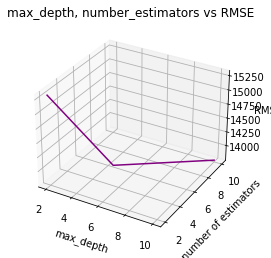

In [13]:
# Code here
# 30/70 data split. 
train_df, test_df = train_test_split(df, test_size=0.70, shuffle = True) #split data set. 
train_Y = train_df['fullyLoaded']
train_X = train_df.drop('fullyLoaded', axis=1)

test_Y = test_df['fullyLoaded']
test_X = test_df.drop('fullyLoaded', axis=1)

# OLS. 
train_X=sm.add_constant(train_X)       
split_90_10= sm.OLS(train_Y, train_X).fit()    
test_X = sm.add_constant(test_X)
test_pred = split_90_10.predict(test_X)

rmse = RMSE(test_Y, test_pred)
print("RMSE for OLS: ", rmse)

# Ridge.
alpha = np.array([10e-10, 10e-5, 10, 10e+5,10e+10]) 
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Ridge(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Ridge alpha", alphaa)
print("Ridge MSE: ",min(mse_error))

# Lasso
coeffecient = []
mse_error = []
alphas = []
for a in alpha: 
    rid = Lasso(a)
    rid.fit(train_X, train_Y)
    prediction_rid = rid.predict(test_X)
    error = mse(test_Y, prediction_rid)
    mse_error.append(error)
    coeffecient.append(rid.coef_)
    alphas.append(a)

i  = mse_error.index(min(mse_error))
alphaa = alphas[i]

print("Lasso alpha", alphaa)
print("Lasso MSE: ",min(mse_error))


# decision tree. 
m = [2,5,10]
predict = []
err = []
for i in m:
    clf = tree.DecisionTreeClassifier(max_depth = i)
    clf = clf.fit(train_X, train_Y)
    predict_y = clf.predict(test_X)
    err.append(RMSE(test_Y, predict_y))
    predict.append(predict_y)

print("decision tree error:", err)



# Random Forest 
m = [2,5,10]
num_est = [100,200,300,100,200,300]
errors = {}
for i in m: 
    e = []
    for j in num_est:
        r_f = RandomForestRegressor(max_depth = i,n_estimators = j )
        r_f.fit(train_X, train_Y)
        pred_r_f = r_f.predict(test_X)
        err = RMSE(test_Y, pred_r_f)
        e.append(err)
    errors[i] = max(e)

f = plt.figure()
axs = plt.axes(projection = '3d')
num_est = list(errors.keys())
rms_error = list(errors.values())
print(len(num_est))

axs.plot3D(m, num_est, rms_error, color = 'purple')
axs.set_title("max_depth, number_estimators vs RMSE")
axs.set_xlabel ("max_depth")
axs.set_ylabel("number of estimators")
axs.set_zlabel("RMSE")
plt.show